In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import json
from copy import copy
from glob import glob
import os
import pickle

In [2]:
from uuid import uuid4
import psycopg2

con = psycopg2.connect(
    host="localhost",
    user="postgres",
    options="-c search_path=public_release",
)

## Data retrieval for Catalyst Discovery Use Case

In [4]:
eche_foms_query = open("eche_foms_query.sql").read()
eche_pets_query = open("eche_pets_query.sql").read()

In [5]:
# remove 'set search_path' lines in query which gives a syntax error with psycopg2
strip_foms_query = "\n".join(eche_foms_query.split("\n")[3:])
strip_pets_query = "\n".join(eche_pets_query.split("\n")[3:])

In [6]:
fcur = con.cursor(name=f"foms_{uuid4()}")
fcur.itersize = 100000
fcur.execute(strip_foms_query)
fomdata = fcur.fetchall()
fomdf = pd.DataFrame(fomdata, columns=[x.name for x in fcur.description])
fcur.close()

In [7]:
pcur = con.cursor(name=f"provs_{uuid4()}")
pcur.itersize = 100000
pcur.execute(strip_pets_query)
provdata = pcur.fetchall()
prcdf = pd.DataFrame(provdata, columns=[x.name for x in pcur.description])
pcur.close()

In [9]:
# filter out 'OCV' measurements as non-state-changing processes
smpdf = copy(
    prcdf.query("~technique.str.startswith('OCV')").sort_values(
        ["sample_label", "timestamp"]
    )
)

In [10]:
# aggregate sample_processes per sample into ordered list
usmpdf = smpdf.groupby("sample_label").agg({"sample_process_id": list})

In [11]:
# extract technique strings
usmpdf["sp_techs"] = smpdf.groupby("sample_label").agg(
    {"technique": lambda x: [y[:-1] for y in x]}
)["technique"]

In [12]:
# extract type strings
usmpdf["sp_types"] = smpdf.groupby("sample_label").agg(
    {"type": list}
)["type"]

In [13]:
# extract durations
usmpdf["sp_durations"] = smpdf.groupby("sample_label").agg(
    {"acquisition_time": list}
)["acquisition_time"]

In [14]:
# count number of previous processes
smpdf["num_prev_procs"] = smpdf.apply(
    lambda x: usmpdf.loc[x["sample_label"]].sample_process_id.index(
        x["sample_process_id"]
    ),
    axis=1,
)

In [15]:
# get pets time based on type and duration
def get_petstime(rowdf):
    udf = usmpdf.loc[rowdf["sample_label"]]
    provlen = rowdf["num_prev_procs"] + 1
    times = udf.sp_durations[:provlen]
    typs = udf.sp_types[:provlen]
    pets_times = [ti for ti, ty in zip(times, typs) if ty == "pets"]
    return sum(pets_times)


smpdf["pets_time"] = smpdf.apply(get_petstime, axis=1)

In [16]:
# construct type-tech-provenance strings
def get_tt(rowdf):
    udf = usmpdf.loc[rowdf['sample_label']]
    provlen = rowdf['num_prev_procs'] + 1
    typs = udf.sp_types[:provlen]
    techs = udf.sp_techs[:provlen]
    return '-'.join([f"{ty.lower()}{te.upper()}" for ty,te in zip(typs, techs)])


smpdf["provenance"] = smpdf.apply(get_tt, axis=1)

In [17]:
# identify provenances with parallel electrochemical measurement (PETS)
smpdf["has_pets"] = smpdf.provenance.str.contains('pets')

In [19]:
fomdf["figure_of_merit"] = fomdf.apply(
    lambda x: x.etav_ave if x.technique.startswith("CP") else x.etav_ithresh, axis=1
)

fomdf["CP"] = fomdf.technique.str.startswith("CP")
fomdf["CV"] = fomdf.technique.str.startswith("CV")

In [20]:
fomdf["current"] = fomdf.apply(
    lambda x: x.current_abs if x.technique.startswith("CP") else float(x.analysis_name[-4:]), axis=1
)

In [21]:
mldf = copy(
    fomdf.set_index("sample_process_id")
    .join(smpdf.set_index("sample_process_id")[["num_prev_procs", "provenance", "has_pets", "pets_time"]])
    .drop(["etav_ave", "etav_ithresh"], axis=1)
)

In [22]:
# must have inkjet composition
mldf = copy(mldf.query("~inkjet_composition.isnull()")).reset_index()

# must have non-NaN figure of merit
mldf = copy(mldf.query("~figure_of_merit.isnull()")).reset_index()

In [24]:
mldf.iloc[0].inkjet_composition

{'Ce': 0.6, 'Co': 0.0, 'Fe': 0.1, 'La': 0.2, 'Mn': 0.0, 'Ni': 0.1}

In [25]:
# agg json composition elements
els = set()

for x in mldf.inkjet_composition:
    # els = els.union(json.loads(x).keys())
    els = els.union(x.keys())

els = sorted(els)

In [26]:
# create composition sets
mldf["compset"] = mldf.inkjet_composition.apply(
    lambda x: tuple(sorted(set([k for k,v in x.items() if v>0])))
)

# create composition vectors
comparray = np.zeros((mldf.shape[0], len(els)))
for i, jd in enumerate(mldf.inkjet_composition):
    for k, v in jd.items():
        comparray[i, els.index(k)] = v

In [27]:
compdf = pd.DataFrame(comparray, columns=els)

In [28]:
mlcomps = pd.concat((mldf, compdf), axis=1)

## XGBoost modeling of subsets A, B, and C for Catalyst Discovery Use Case

In [29]:
# additional features for ML modeling
more_cols = [
    "max_temperature",
    "num_prev_procs",
    "solution_ph",
    "current",
    "pets_time",
    "CP",
    "CV",
]

In [288]:
# set A: threshold current 3e-5
dfA = mlcomps.query("current==3e-5")

# set B: deduplicate samples by longest provenance, threshold current 3e-5, temperature ~400C
dfB = (
    dfA.query("max_temperature>=390 & max_temperature<=410")
    .sort_values("num_prev_procs", ascending=False)
    .drop_duplicates("sample_label")
)

# set C: deduplicate samples by longest provenance, threshold current 3e-5, solution pH ~13, pets_time>0
dfC = (
    dfB.query("solution_ph > 12.7 & solution_ph < 13.5")
    .query("pets_time > 0")
)

In [289]:
from itertools import combinations as comb
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [290]:
# holdout quaternary sets for prediction (and ternary combinations)
quaternary_sets = sorted(set([s for s in dfC.compset if len(s)==4]))

In [291]:
result_dict = {}
resultp_dict = {}
preds_list = []

# predict set C quaternary and ternary compositions
for qs in tqdm(quaternary_sets):
    holdout_sets = [qs] + list(comb(qs, 3))
    predbool = dfC.compset.isin(holdout_sets)
    preds = copy(dfC[predbool][els + ["figure_of_merit"]])
    preds["quatern"] = "-".join(qs)
    for setlab, setdf in [('A', dfA), ('B', dfB), ('C', dfC)]:
        holdout = setdf.compset.isin(holdout_sets)
        # composition-only input
        X_train = copy(setdf[~holdout][els].to_numpy())
        y_train = copy(setdf[~holdout]["figure_of_merit"].to_numpy())
        X_test = copy(dfC[predbool][els].to_numpy())
        y_test = copy(dfC[predbool]["figure_of_merit"].to_numpy())
        if y_test.shape[0]==0:
            continue
        xgb = XGBRegressor(random_state=1000)
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        preds[f"pred_{setlab}_comp"] = y_pred
        phase_result = {
            "train_size": y_train.shape[0],
            "test_size": y_test.shape[0],
            "MAE": mean_absolute_error(y_test, y_pred),
            "model": xgb,
        }
        result_dict[(qs, setlab)] = phase_result

        # composition + solution_ph, current, technique, etc...
        Xp_train = copy(setdf[~holdout][more_cols + els].to_numpy())
        yp_train = copy(setdf[~holdout]["figure_of_merit"].to_numpy())
        Xp_test = copy(dfC[predbool][more_cols + els].to_numpy())
        yp_test = copy(dfC[predbool]["figure_of_merit"].to_numpy())
        xgbp = XGBRegressor(random_state=1000)
        xgbp.fit(Xp_train, yp_train)
        yp_pred = xgbp.predict(Xp_test)
        preds[f"pred_{setlab}_plus"] = yp_pred
        phasep_result = {
            "train_size": yp_train.shape[0],
            "test_size": yp_test.shape[0],
            "MAE": mean_absolute_error(yp_test, yp_pred),
            "model": xgbp,
        }
        resultp_dict[(qs, setlab)] = phasep_result
    preds_list.append(preds)

  0%|          | 0/63 [00:00<?, ?it/s]

In [292]:
result_df = (
    pd.DataFrame(result_dict)
    .T.reset_index()
    .rename(columns={"level_0": "compset", "level_1": "phase"})
)
resultp_df = (
    pd.DataFrame(resultp_dict)
    .T.reset_index()
    .rename(columns={"level_0": "compset", "level_1": "phase"})
)
result_df["input"] = "comp"
resultp_df["input"] = "comp++"
result_melt = result_df.melt(id_vars=["compset", "phase", "input"])
resultp_melt = resultp_df.melt(id_vars=["compset", "phase", "input"])

In [293]:
all_preds = pd.concat(preds_list)
all_results = pd.concat((result_df, resultp_df))

In [294]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [295]:
all_results["total_size"] = all_results.train_size + all_results.test_size
agg_results = all_results.drop(["model"], axis=1).groupby(["phase", "input"]).mean()

# test size weighted avg
agg_results["MAE"] = all_results.drop(["model"], axis=1).groupby(["phase", "input"]).apply(
    wavg, "MAE", "test_size"
)

/tmp/ipykernel_84541/966844043.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_results = all_results.drop(["model"], axis=1).groupby(["phase", "input"]).mean()


In [296]:
agg_results

train_size   test_size       MAE     total_size
phase input                                                     
A     comp    645358.365079  621.793651  0.376947  645980.158730
      comp++  645358.365079  621.793651  0.529407  645980.158730
B     comp     64623.873016  621.793651  0.156117   65245.666667
      comp++   64623.873016  621.793651  0.053850   65245.666667
C     comp     19390.206349  621.793651  0.052706   20012.000000
      comp++   19390.206349  621.793651  0.058854   20012.000000

In [297]:
agg_results.rename(
    columns={
        "train_size": "mean_train_size",
        "test_size": "mean_test_size",
        "total_size": "mean_total_size",
    },
    inplace=True,
)
agg_results.reset_index(inplace=True)

In [298]:
agg_results

,phase,input,mean_train_size,mean_test_size,MAE,mean_total_size
0,A,comp,645358.365079,621.793651,0.376947,645980.158730
1,A,comp++,645358.365079,621.793651,0.529407,645980.158730
2,B,comp,64623.873016,621.793651,0.156117,65245.666667
3,B,comp++,64623.873016,621.793651,0.053850,65245.666667
4,C,comp,19390.206349,621.793651,0.052706,20012.000000
5,C,comp++,19390.206349,621.793651,0.058854,20012.000000


## Figure 5 lineplot and composition map

In [403]:
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
rcDefaults = copy(rcParams)

In [388]:
rcParams['figure.facecolor'] = 'w'
rcParams['figure.dpi'] = 300

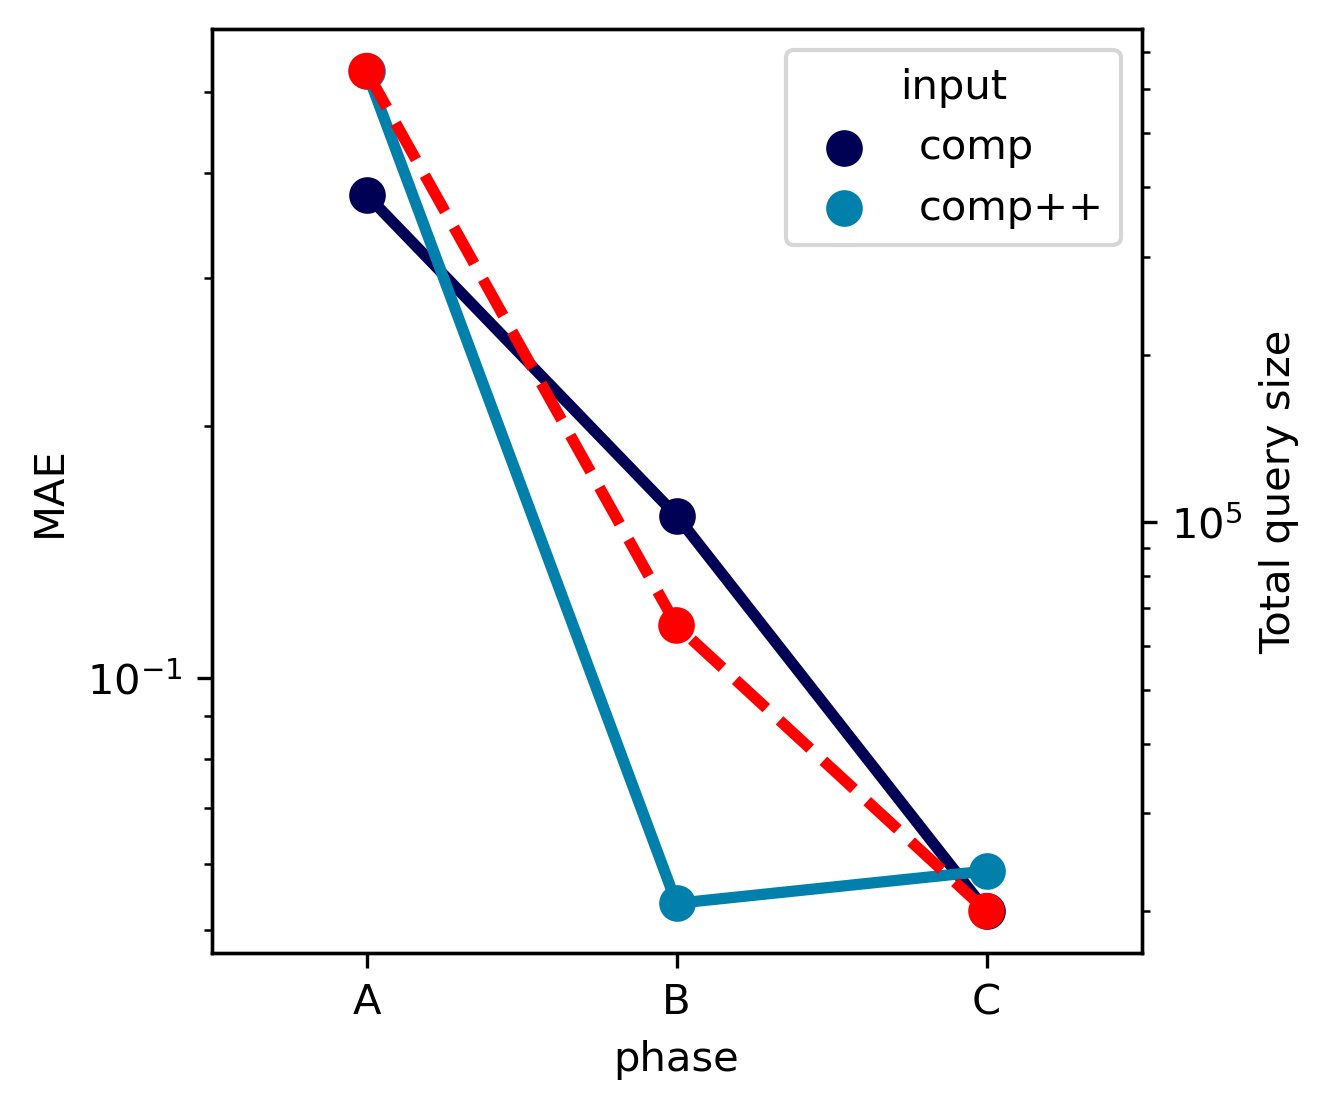

In [423]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
g = sns.pointplot(
    data=agg_results.sort_values(["phase", "input"]),
    x="phase",
    y="MAE",
    hue="input",
    palette="ocean",
    ax=ax
)
g.set(yscale="log")
g.set_ylabel("MAE")
ax2 = plt.twinx()
sns.pointplot(
    data=agg_results.sort_values(["phase", "input"]),
    x="phase",
    y="mean_total_size",
    color="red",
    ax=ax2,
    linestyles="--",
)
ax2.set_yscale("log")
ax2.set_ylabel("Total query size")
plt.savefig("aggregate_plot_quatsetC.svg")

In [300]:
pickle.dump(all_results, open("all_results_v4.pck", "wb"))
pickle.dump(all_preds, open("all_preds_v4.pck", "wb"))

In [301]:
from quaternary_faces_shells import ternaryfaces_shells
from myquaternaryutility import QuaternaryPlot

In [302]:
all_results = pickle.load(open("all_results_v4.pck", "rb"))
all_preds = pickle.load(open("all_preds_v4.pck", "rb"))

In [362]:
cset = ('Ce', 'Fe', 'Mn', 'Ni')

In [363]:
# calculate errors
pdf = copy(all_preds.query(f"quatern=='{'-'.join(cset)}'"))
pcols = [x for x in pdf.columns if x.startswith('pred_')]
ecols = [x.replace('pred_', 'err_') for x in pcols]

for p,e in zip(pcols, ecols):
    pdf[e] = pdf[p] - pdf['figure_of_merit']

In [367]:
cels = list(cset)
mdf = pdf[cels+ecols+pcols+["figure_of_merit"]].groupby(cels).mean().reset_index()
mdf[cels] = np.round(mdf[cels]*100)  # round to avoid floating point errors with modulo

# data for plotting 10 at.% intervals
qdata = mdf.query(" & ".join([f"{e}%10==0" for e in cels]))

In [382]:
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

sm = ScalarMappable(norm=Normalize(vmin=0.3, vmax=0.65), cmap=sns.palettes.mpl_palette('inferno_r', as_cmap=True))
intervs = 10 

In [386]:
MAEs = mdf[ecols].abs().mean()

Text(3.7, 0.525, 'MAE: 0.143 V')

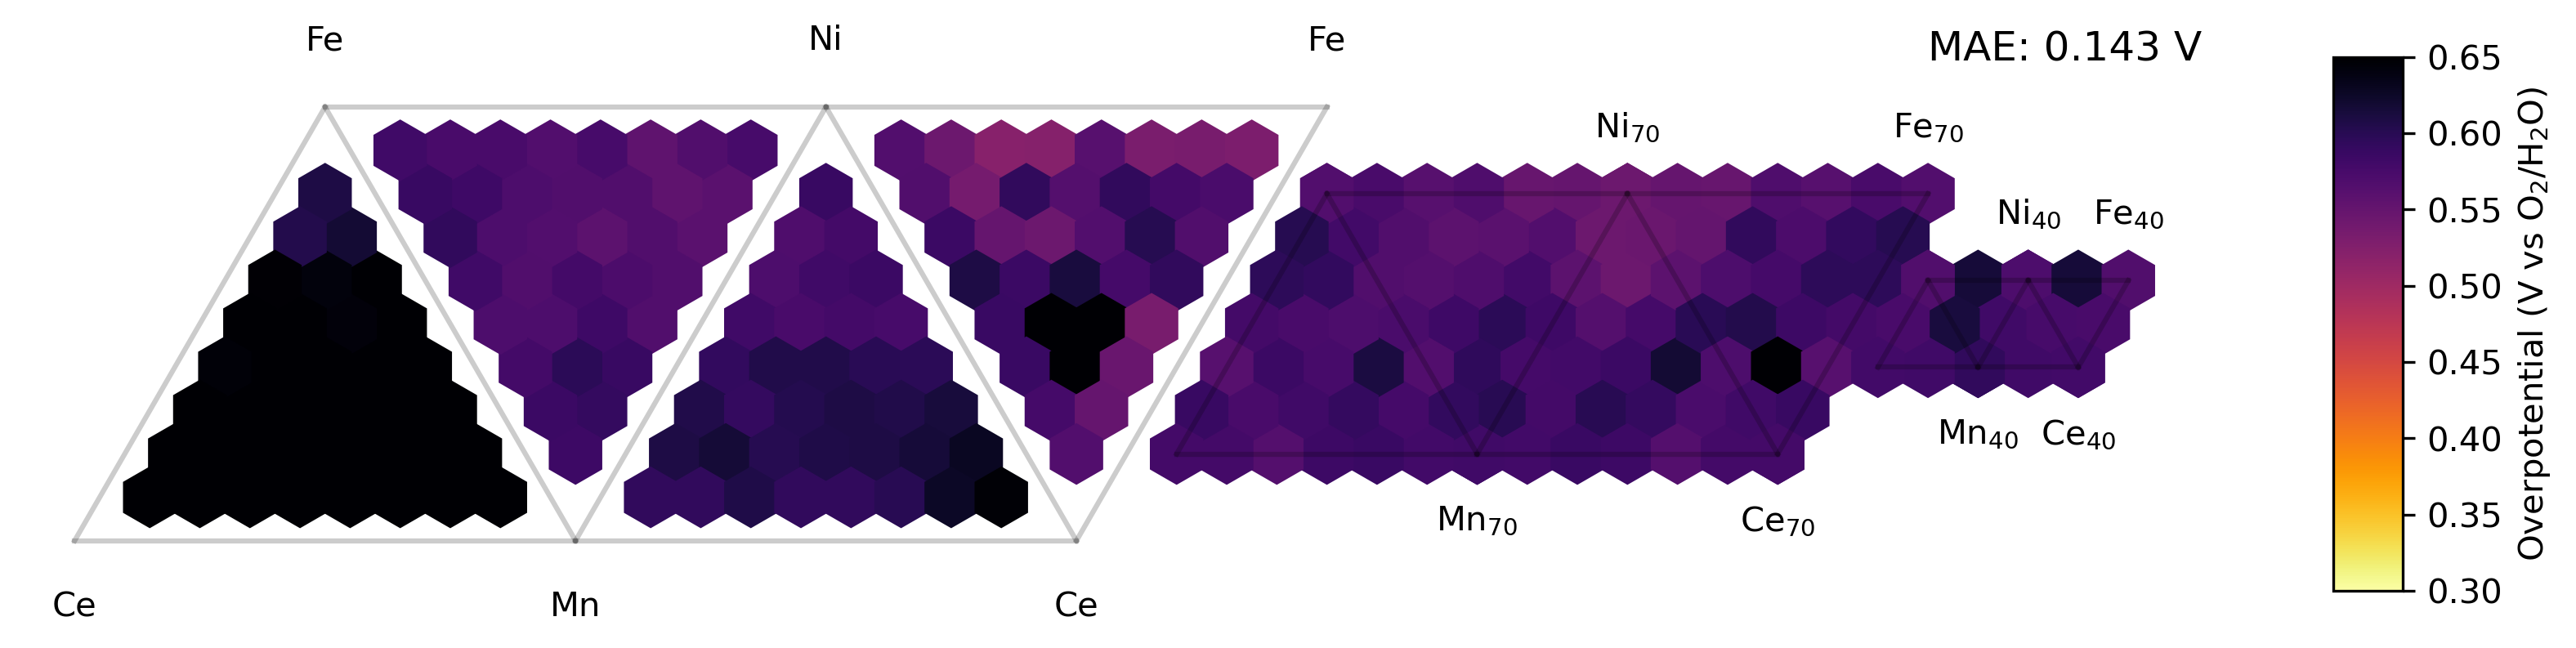

In [449]:
cs = np.array([sm.to_rgba(x) for x in qdata.pred_B_comp])
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot()
tf = ternaryfaces_shells(ax, ellabels=cels, nintervals=intervs)
tf.scatter(qdata[cels].to_numpy()/100, cs, skipinds=[0, 1, 2, 3], s='patch')
tf.label()
fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02)
plt.colorbar(sm, cax=cax, label="Overpotential (V vs O$_2$/H$_2$O)")
ax.annotate(f"MAE: {MAEs.err_B_comp:.3f} V", xy=(3.7, 0.525), size=12)

Text(3.7, 0.525, 'MAE: 0.025 V')

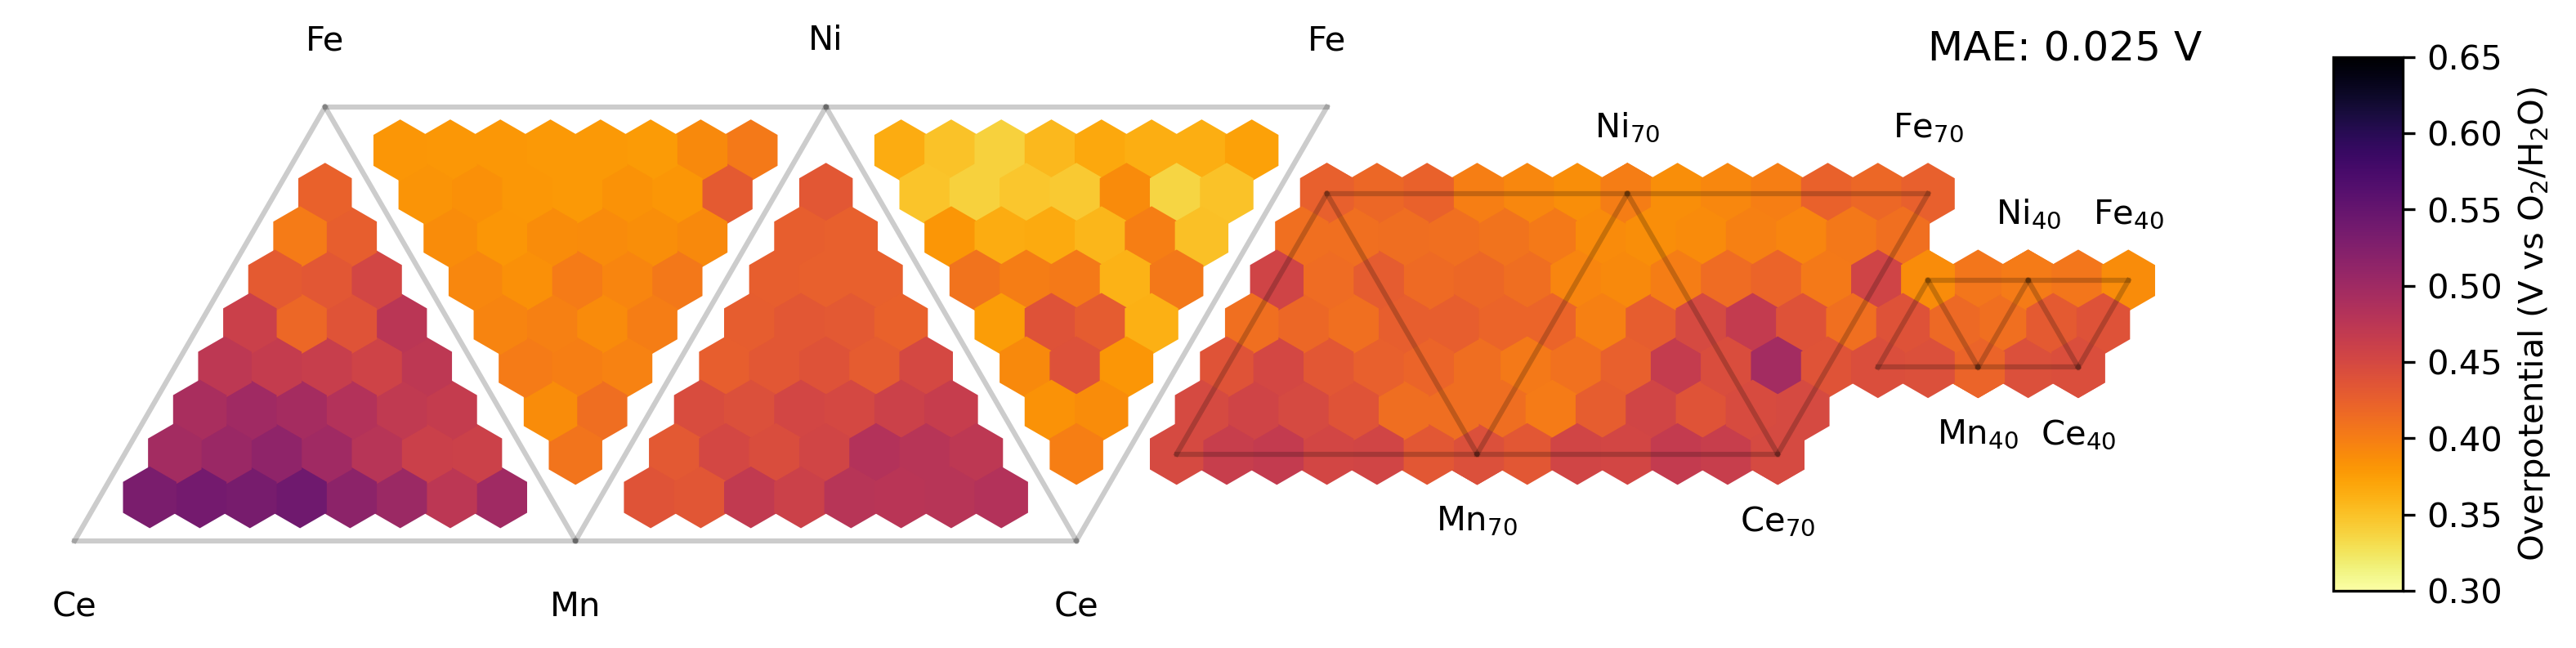

In [450]:
cs = np.array([sm.to_rgba(x) for x in qdata.pred_B_plus])
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot()
tf = ternaryfaces_shells(ax, ellabels=cels, nintervals=intervs)
tf.scatter(qdata[cels].to_numpy()/100, cs, skipinds=[0, 1, 2, 3], s='patch')
tf.label()
fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02)
plt.colorbar(sm, cax=cax, label="Overpotential (V vs O$_2$/H$_2$O)")
ax.annotate(f"MAE: {MAEs.err_B_plus:.3f} V", xy=(3.7, 0.525), size=12)

Text(3.7, 0.525, 'ground truth')

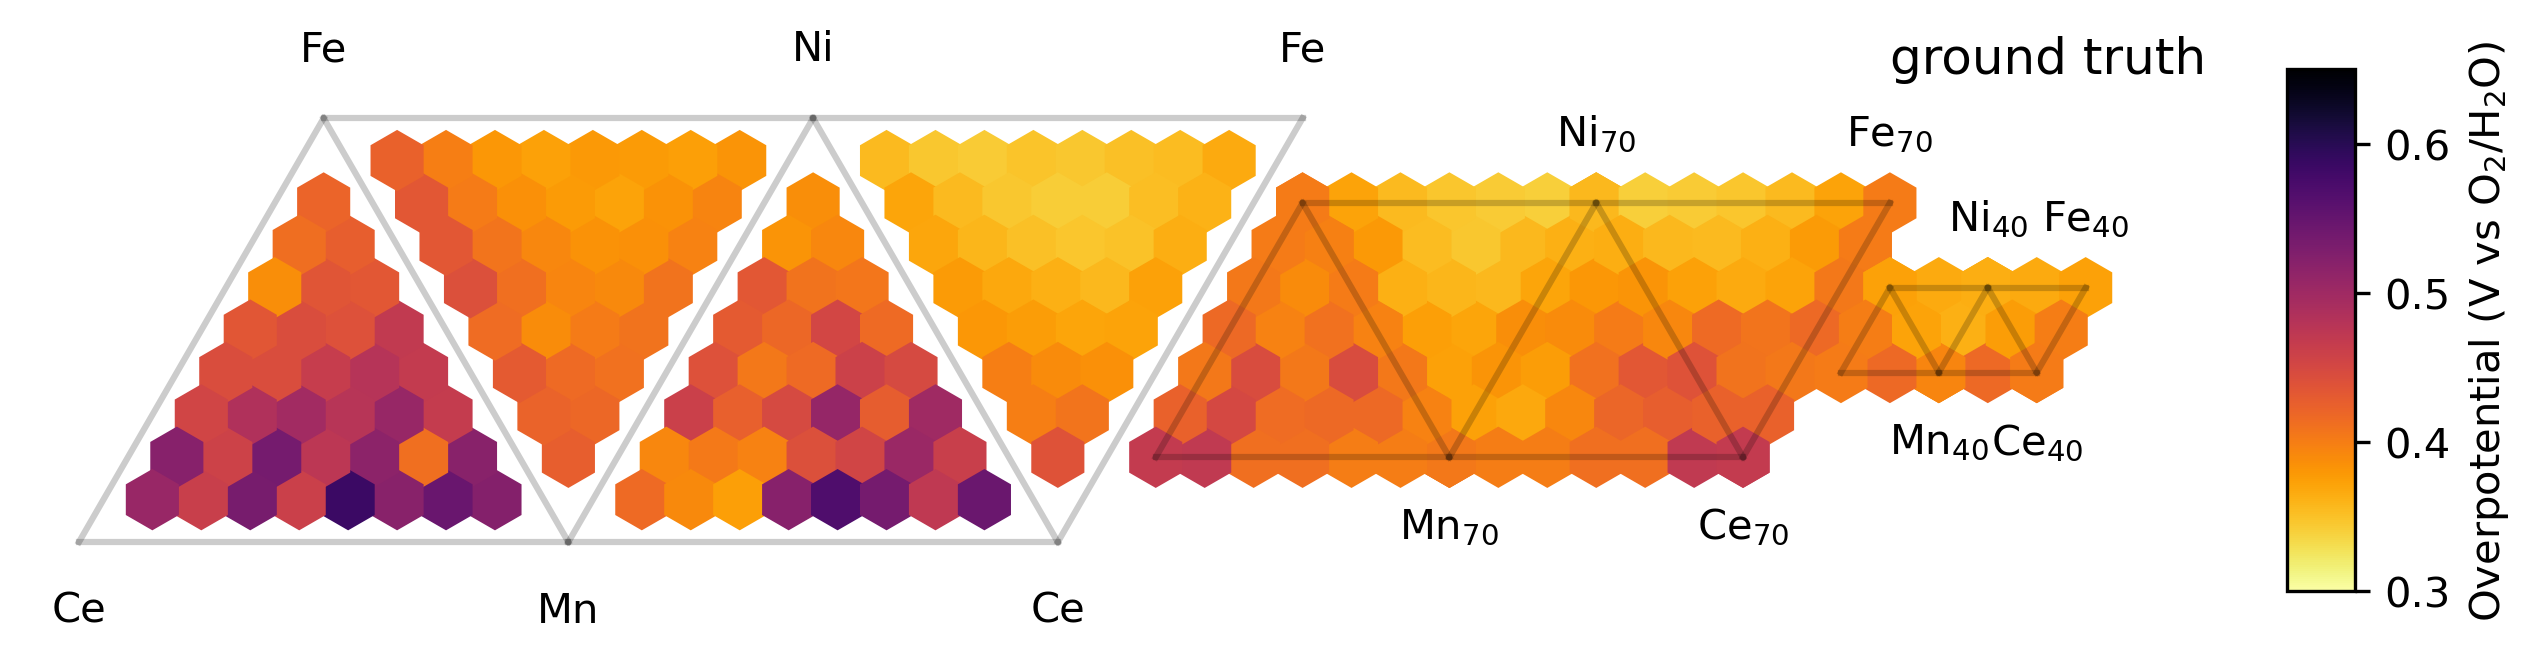

In [448]:
cs = np.array([sm.to_rgba(x) for x in qdata.figure_of_merit])
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot()
tf = ternaryfaces_shells(ax, ellabels=cels, nintervals=intervs)
tf.scatter(qdata[cels].to_numpy()/100, cs, skipinds=[0, 1, 2, 3], s='patch')
tf.label()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02)
plt.colorbar(sm, cax=cax, label="Overpotential (V vs O$_2$/H$_2$O)")
ax.annotate(f"ground truth", xy=(3.7, 0.525), size=12)